In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

In [7]:
#check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [8]:
data_df = pd.read_csv('./data/riceClassification.csv')
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [9]:
data_df.dropna(inplace=True)
data_df.drop(columns=['id'], inplace=True)
print(data_df.shape)

(18185, 11)


In [11]:
print(data_df['Class'].value_counts())

Class
1    9985
0    8200
Name: count, dtype: int64


In [12]:
original_df = data_df.copy()

for column in data_df.columns:
    data_df[column] = data_df[column]/data_df[column].abs().max()

data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [13]:
X = np.array(data_df.iloc[:, :-1])
Y = np.array(data_df.iloc[:, -1])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [15]:
X_train.shape, X_val.shape, X_test.shape

((12729, 10), (2728, 10), (2728, 10))

In [16]:
class dataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.Y = torch.tensor(Y, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [17]:
training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

In [18]:
train_dataloader = DataLoader(training_data, batch_size=8, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=8, shuffle=False)
testing_dataloader = DataLoader(testing_data, batch_size=8, shuffle=False)

In [19]:
HIDDEN_NEURONS = 20

class RiceModel(nn.Module):
    def __init__(self):
        super(RiceModel, self).__init__()
        self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
        self.linear = nn.Linear(HIDDEN_NEURONS, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x
    
model = RiceModel().to(device)

In [21]:
summary(model,(X.shape[1],))

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 20]                  220
├─Linear: 1-2                            [-1, 1]                   21
├─Sigmoid: 1-3                           [-1, 1]                   --
Total params: 241
Trainable params: 241
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 20]                  220
├─Linear: 1-2                            [-1, 1]                   21
├─Sigmoid: 1-3                           [-1, 1]                   --
Total params: 241
Trainable params: 241
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [22]:
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [23]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

epochs = 10
for epoch in range(epochs):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    # Training phase (batch-wise)
    for data in train_dataloader:
        inputs, labels = data

        prediction = model(inputs).squeeze(1)

        batch_loss = criterion(prediction, labels)
        total_loss_train += batch_loss.item()

        acc = (prediction.round() == labels).sum().item()
        total_acc_train += acc

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    with torch.no_grad():
        for data in validation_dataloader:
            inputs, labels = data

            prediction = model(inputs). squeeze(1)

            batch_loss = criterion(prediction, labels)
            total_loss_val += batch_loss.item()

            acc = (prediction.round() == labels).sum().item()
            total_acc_val += acc

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    total_acc_train_plot.append(round(total_acc_train/training_data.__len__() * 100, 4))
    total_acc_validation_plot.append(round(total_acc_val/validation_data.__len__() * 100, 4))

    print(f"Epoch no. {epoch+1}/{epochs} Train Loss: {total_loss_train/1000:.4f} "
          f"Train Accuracy: {total_acc_train/training_data.__len__() * 100:.4f} "
          f"Validation Loss: {total_loss_val/1000:.4f} "
          f"Validation Accuracy: {total_acc_val/validation_data.__len__() * 100:.4f}")
    
    print("="*25)

Epoch no. 1/10 Train Loss: 0.4904 Train Accuracy: 92.0339 Validation Loss: 0.0294 Validation Accuracy: 98.4604
Epoch no. 2/10 Train Loss: 0.1051 Train Accuracy: 98.3659 Validation Loss: 0.0177 Validation Accuracy: 98.6437
Epoch no. 3/10 Train Loss: 0.0777 Train Accuracy: 98.4681 Validation Loss: 0.0158 Validation Accuracy: 98.6070
Epoch no. 4/10 Train Loss: 0.0721 Train Accuracy: 98.5545 Validation Loss: 0.0187 Validation Accuracy: 98.2405
Epoch no. 5/10 Train Loss: 0.0694 Train Accuracy: 98.4759 Validation Loss: 0.0150 Validation Accuracy: 98.6070
Epoch no. 6/10 Train Loss: 0.0707 Train Accuracy: 98.5702 Validation Loss: 0.0154 Validation Accuracy: 98.5704
Epoch no. 7/10 Train Loss: 0.0696 Train Accuracy: 98.5152 Validation Loss: 0.0164 Validation Accuracy: 98.2771
Epoch no. 8/10 Train Loss: 0.0677 Train Accuracy: 98.5388 Validation Loss: 0.0173 Validation Accuracy: 98.4238
Epoch no. 9/10 Train Loss: 0.0694 Train Accuracy: 98.4995 Validation Loss: 0.0151 Validation Accuracy: 98.5337
E

In [24]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for data in testing_dataloader:
        inputs, labels = data

        prediction = model(inputs).squeeze(1)

        batch_loss_test = criterion(prediction, labels)
        total_loss_test += batch_loss_test.item()

        acc = (prediction.round() == labels).sum().item()
        total_acc_test += acc

print(f"Test Loss: {total_loss_test/1000:.4f} ")
print(f"Test Accuracy: {total_acc_test/testing_data.__len__() * 100:.4f}")

Test Loss: 0.0098 
Test Accuracy: 98.9003


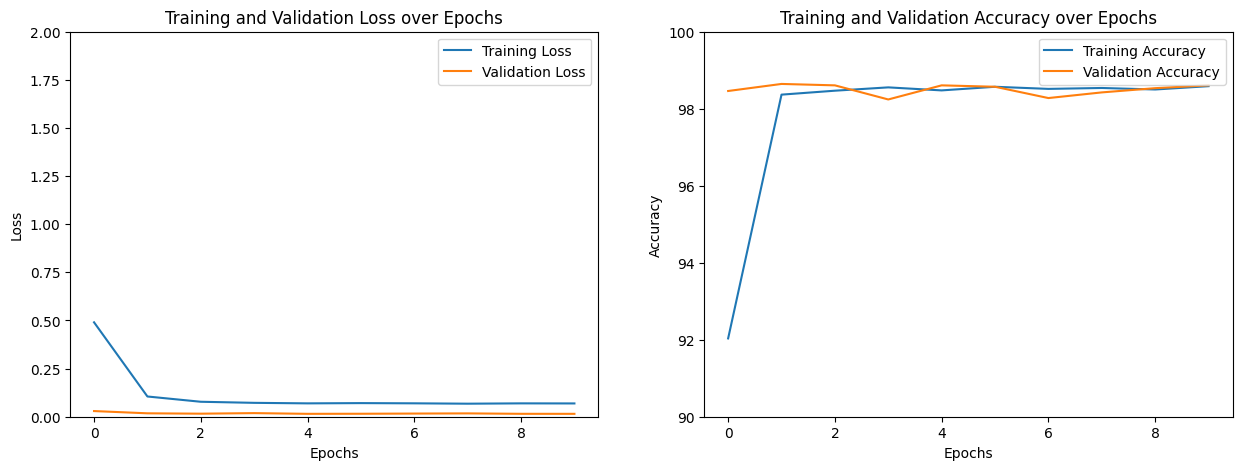

In [28]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0,2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([90,100])
axs[1].legend()

In [30]:
#inference
area = 2353/original_df['Area'].abs().max()
MajorAxisLength = 81/original_df['MajorAxisLength'].abs().max()
MinorAxisLength = 43/original_df['MinorAxisLength'].abs().max()
Eccentricity = 32/original_df['Eccentricity'].abs().max()
ConvexArea = 12/original_df['ConvexArea'].abs().max()
EquivDiameter = 33/original_df['EquivDiameter'].abs().max()
Extent = 98/original_df['Extent'].abs().max()
Perimeter = 927/original_df['Perimeter'].abs().max()
Roundness = 677/original_df['Roundness'].abs().max()
AspectRation = 24/original_df['AspectRation'].abs().max()

prediction = model(torch.tensor([area, MajorAxisLength, MinorAxisLength, Eccentricity, ConvexArea,
    EquivDiameter, Extent, Perimeter, Roundness, AspectRation], dtype=torch.float32).to(device))

print(f"Prediction: {prediction.item()}")

Prediction: 0.0
